Thanks for checking on my notebook! For suggestions or to connect, please follow the link https://www.linkedin.com/in/juansgalindo/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import requests
import json

from config import gkey

In [2]:
#Load CSV path.
stageData = pd.read_csv('SampleCSV.csv')

#Visualize Column Names. 
stageData.columns


Index(['Time', 'Job Time', 'Chem 1 Conc - C1', 'Chem 2 Tote Conc - C2',
       'Chem 3 Tote Conc - C3', 'Chem4 Conc - C4', 'Chem 5 Conc - C5',
       'Chem 6 Conc - C6', 'Chem 7 Conc - C7', 'Chem 8 Conc - C8',
       'Chem 9 Conc - C9', 'Chem 10 Conc - C10', 'Chem 1 Total - C1',
       'Chem 2 Tote Total - C2', 'Chem 3 Tote - C3', 'Chem 4 Total - C4',
       'Chem 5 - C5 Total', 'Chem 6 Total - C6', 'Chem 7 Total - C7',
       'Chem 8 Total - C8', 'Chem 9  Total - C9', 'Chem 10 Total - C10',
       'H1 Conc', 'BU Gel Conc', 'Primay Gel Conc', 'H1 Total', 'H2Total',
       'Primary Gel Total', 'Surf Stage Number', 'Well Side PSI',
       'Pump Side PSI', 'Combined Clean Rate', 'Combined Slurry Rate',
       'Combined Clean Total', 'Combined Slurry Total', 'Wellhead Inline PPA',
       'Wellhead Blender PPA', 'Wellhead Screw PPA', 'Screw Prop Total',
       'Blender Prop Total', 'Inline Prop Total', 'Meas'd Btmh Press',
       'Btm Prop Conc', 'Prop Stage Tot', 'Slurry Stage Tot',
      

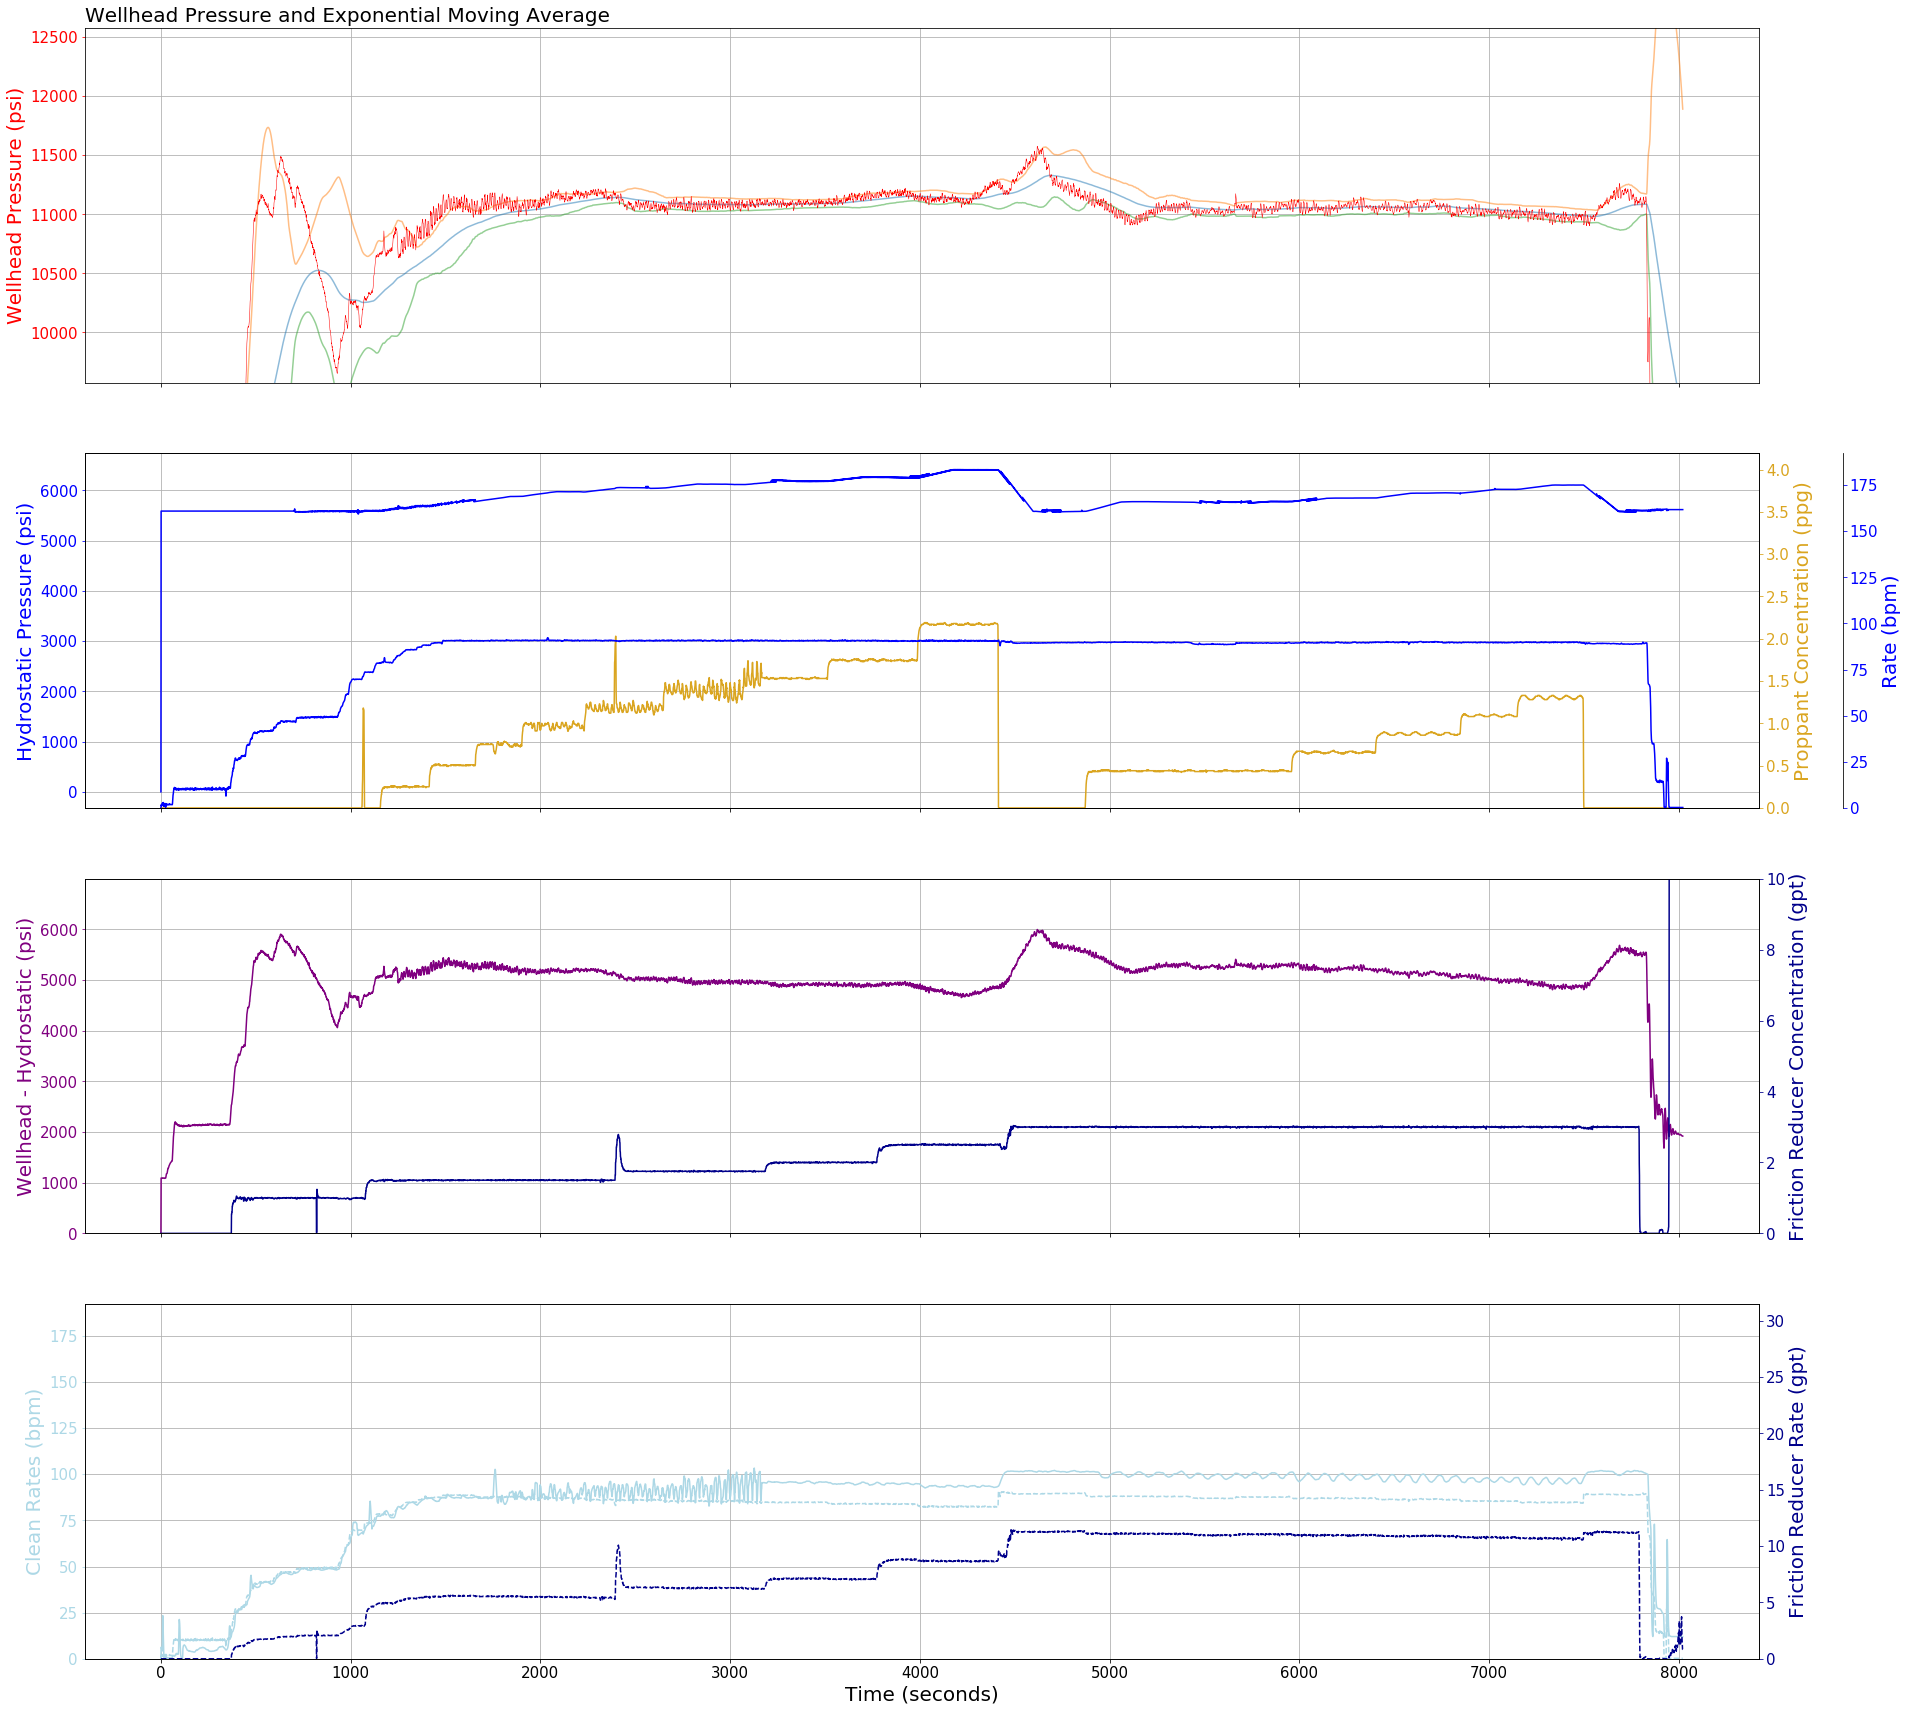

In [3]:
#Imported Varaibles for the stage. 
tvd = 12885
topPerf = 16052
pipeCapacity = 0.02119
baseFluidDensity = 8.34
proppantSG = 2.65
AverageRate = 90

#Calculated Variables
flushVolume = pipeCapacity * topPerf
baseFluidHydrostatic = 0.052 * baseFluidDensity * tvd
sandAbsVol = 1 / (proppantSG * baseFluidDensity)
pipeTime = flushVolume/AverageRate 

#First row from field CSV used are units for each channel. 
stageData.loc[0,:] = 0

#Change the title for each channel to make sure they match the CSV.
#Imported CSV DataFrame is converted to lists.
#In my experience working with lists allows the code to run faster than dealing with DataFrames.
jobTime = pd.to_numeric(stageData['Time']).to_list()
rate = pd.to_numeric(stageData['Combined Slurry Rate']).to_list()
cleanRate = pd.to_numeric(stageData['Combined Clean Rate']).to_list()
wellheadPressure = pd.to_numeric(stageData['Well Side PSI']).to_list()
slurryTotal = pd.to_numeric(stageData['Combined Slurry Total']).to_list()
proppantTotal = pd.to_numeric(stageData['Screw Prop Total']).to_list()
proppantConc = pd.to_numeric(stageData['Wellhead Screw PPA']).to_list()

#Show combined concentration for each chemical.
frictionReducer = (pd.to_numeric(stageData['Chem 8 Conc - C8']) + pd.to_numeric(stageData['Chem 10 Conc - C10'])).to_list()

#Code to calculate hydrostatic, clean total clean rate, chemical pump rates.
for i in range(len(stageData)):
    if (i == 0):
        cleanBblCount = [0]
        fluidDensity = [baseFluidDensity]
        fluidHeight = [0] 
        totalHeight = [0]
        hydrostatic = [0]
        differentialPressure = [0]
        caclCleanRate =[0]
        calcChemRate = [0]
        continue

    elif (proppantConc[i] == 0):

        cleanBblCount.append((slurryTotal[i] - slurryTotal[i-1]) + cleanBblCount[i-1])
        fluidDensity.append(baseFluidDensity)
        caclCleanRate.append(rate[i])
    else:
        cleanBblCount.append(round(((slurryTotal[i] -  slurryTotal[i-1]) / ((1/(baseFluidDensity * proppantSG)) * proppantConc[i] + 1)) + cleanBblCount[i-1],2))
        fluidDensity.append((baseFluidDensity + proppantConc[i]) / ((proppantConc[i] * sandAbsVol) +1))
        caclCleanRate.append(round(((rate[i]) / ((1/(baseFluidDensity * proppantSG)) * proppantConc[i] + 1)),2))

    fluidHeight.append(round(((slurryTotal[i] - slurryTotal[i-1])/ pipeCapacity),2)) 
    totalHeight.append(fluidHeight[i] + totalHeight[i-1]) 
    calcChemRate.append(0.042 * frictionReducer[i] * caclCleanRate[i])

    if( totalHeight[i] <= tvd): 

        tempHeightList = fluidHeight[0 : i]

        densityList = fluidDensity[0 : i]

        hydrostaticTemp = (0.052) * sum([tempHeightList[j] * densityList[j] for j in range(len(tempHeightList))])
            
        if hydrostaticTemp <= baseFluidHydrostatic:

           hydrostatic.append(baseFluidHydrostatic)

        else:
            hydrostatic.append(hydrostaticTemp)
            
        if hydrostatic[i] <= baseFluidHydrostatic:
           hydrostatic[i] = baseFluidHydrostatic
           
    else:
        tempLowHeightIndex = totalHeight.index(min(totalHeight, key=lambda x:abs(x - (totalHeight[i]-tvd))))
        
        tempHeightList = fluidHeight[tempLowHeightIndex : i]

        densityList = fluidDensity[tempLowHeightIndex : i]

        hydrostaticTemp = (0.052) * sum([tempHeightList[j] * densityList[j] for j in range(len(tempHeightList))])

        hydrostatic.append(hydrostaticTemp)
        
    differentialPressure.append(wellheadPressure[i] - hydrostatic[i])

#Build DataFrame
stage_dict = {
'Rate (bpm)' : rate,
'Wellhead Pressure (psi)' : wellheadPressure,
'Clean Total (bbls)' : cleanBblCount,
'Slurry Total (bbls)' : slurryTotal,
'Proppant Total (lbs)' : proppantTotal,
'Proppant Concentration (ppg)' : proppantConc,
'Hydrostatic (psi)' : hydrostatic,
'Wellhead - Hydrostatic (psi)' : differentialPressure,
'Friction Reducer (gpt)' : frictionReducer,
'Actual Clean Rate (bbls)' : cleanRate,
'Calculated Clean Rate (bbls)' : caclCleanRate,
'Calcualted Friction Reducer Rate (gpm)' : calcChemRate,

}

stage_df = pd.DataFrame(stage_dict)

#Plot------------------------------------- Due to the calculations involved to calculate hydrostatic, We cant plot this live yet!
#Closes all other graphics running.
plt.close()


#https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
%matplotlib inline

#timeframe is set for pipeTime based on job average rate.
#Adjust: Divide by decaying adjustment factor in beginning periods to account for imbalance in relative weightings (viewing EWMA as a moving average)
#com: Specify decay in terms of center of mass --> Smoothing of the graph.
exponentialMovingAverage = pd.Series(stage_df['Wellhead Pressure (psi)']).ewm(min_periods = int(pipeTime * 60), com = (pipeTime * 60), adjust = True).mean()
movingavgSTD = pd.Series(stage_df['Wellhead Pressure (psi)']).rolling(window = int(pipeTime * 60)).std()

#Creates the figure.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize = (30,30), sharex= True)

#plot 1

ax1.set_title('Wellhead Pressure and Exponential Moving Average',fontsize = 20, loc = 'left')
ax1.plot(exponentialMovingAverage, alpha = 0.5)

#https://en.wikipedia.org/wiki/Bollinger_Bands
bandUpExp = exponentialMovingAverage + (movingavgSTD * 2)
lowBandExp = exponentialMovingAverage - (movingavgSTD * 2)

ax1.plot(bandUpExp, alpha = 0.5)
ax1.plot(lowBandExp, alpha = 0.5)

plt1, = ax1.plot(stage_df['Wellhead Pressure (psi)'], color = 'r', lw = 0.5)

ax1.set_ylim(stage_df['Wellhead Pressure (psi)'].max()-2000, stage_df['Wellhead Pressure (psi)'].max()+1000)
ax1.set_ylabel('Wellhead Pressure (psi)', fontsize = 20)
ax1.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors = plt1.get_color())
ax1.yaxis.label.set_color(plt1.get_color())

ax1.grid()

#When the bands separate by an unusual large amount, volatility increases. 

#plot 2

plt2, = ax2.plot(stage_df.index, stage_df['Hydrostatic (psi)'], color = 'blue')

ax2.set_ylabel('Hydrostatic Pressure (psi)', fontsize = 20)
ax2.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors = plt2.get_color())
ax2.yaxis.label.set_color(plt2.get_color())

ax2A = ax2.twinx()

plt2A, = ax2A.plot(stage_df.index,stage_df['Proppant Concentration (ppg)'],color = 'goldenrod')

ax2A.set_ylim(0, stage_df['Proppant Concentration (ppg)'].max()+2)
ax2A.set_ylabel('Proppant Concentration (ppg)', fontsize = 20)
ax2A.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors = plt2A.get_color())
ax2A.yaxis.label.set_color(plt2A.get_color())   

ax2.grid()

ax2B = ax2.twinx()

plt2B, = ax2B.plot(stage_df.index, stage_df['Rate (bpm)'], color = 'blue')

ax2B.set_ylim(0,stage_df['Rate (bpm)'].max()+100)
ax2B.set_ylabel('Rate (bpm)', fontsize = 20)
ax2B.set_xlabel('time (sec)', fontsize = 15)
ax2B.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors=plt2B.get_color())
ax2B.spines["right"].set_position(("axes", 1.05))
ax2B.set_ylim(ax2B.get_ylim()[0], ax2B.get_ylim()[1])
ax2B.yaxis.label.set_color(plt2B.get_color())

#plot 3
plt3, = ax3.plot(stage_df.index, stage_df['Wellhead - Hydrostatic (psi)'], color = 'purple')
ax3.set_ylim(0, stage_df['Wellhead - Hydrostatic (psi)'].max() + 1000)
ax3.set_ylabel('Wellhead - Hydrostatic (psi)', fontsize = 20)

ax3.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors=plt3.get_color())
ax3.yaxis.label.set_color(plt3.get_color())

ax3.tick_params(axis='x',
                which='major',
                labelsize = 15)

ax3A = ax3.twinx()

plt3A, = ax3A.plot(stage_df.index,stage_df['Friction Reducer (gpt)'],color = 'darkblue')
ax3A.set_ylim(0, 10)
ax3A.set_ylabel('Friction Reducer Concentration (gpt)', fontsize = 20)

ax3A.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors=plt3A.get_color())
ax3A.yaxis.label.set_color(plt3A.get_color())

ax3.grid()

#plot 4

plt4, = ax4.plot(stage_df.index, stage_df['Actual Clean Rate (bbls)'], color = 'lightblue')

ax4.set_ylabel('Clean Rates (bpm)', fontsize = 20)
ax4.plot(stage_df.index, stage_df['Calculated Clean Rate (bbls)'], color = 'lightblue', linestyle='dashed')
ax4.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors = plt4.get_color())
ax4.yaxis.label.set_color(plt4.get_color())
ax4.set_ylim(ax2B.get_ylim()[0], ax2B.get_ylim()[1])
ax4.grid()

ax4A = ax4.twinx()

plt4A, = ax4A.plot(stage_df.index,stage_df['Calcualted Friction Reducer Rate (gpm)'],color = 'darkblue',linestyle='dashed')
ax4A.set_ylim(0, stage_df['Calcualted Friction Reducer Rate (gpm)'].max() + 20)
ax4A.set_ylabel('Friction Reducer Rate (gpt)', fontsize = 20)
ax4A.tick_params(axis='y',
                which='major',
                labelsize = 15,
                colors=plt4A.get_color())
ax4A.yaxis.label.set_color(plt4A.get_color())

#X axis
ax4.set_xlabel('Time (seconds)', fontsize = 20)
ax4.tick_params(axis='x',
                which='major',
                labelsize = 15)

#Export png
plt.savefig('outputImage.png')

plt.show()




In [14]:
#Live Plots-------------

#To switch from qt to inline we need to close the prio plot.
plt.close()

#https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
%matplotlib tk

#plt.style.use('fivethirtyeight')

fontsizeTicks = 10
fontsizeYlabel = 15

#function to import data.
def data():
    
    csvData = pd.read_csv('simulationOutput.csv')

    time = csvData['Job Time (min)'].to_list()
    pressure = csvData['Pressure (psi)'].to_list()
    rate = csvData['Dirty Rate (bpm)'].to_list()
    sandConc = csvData['Proppant Conc (ppg)'].to_list()
    frictionReducer = csvData['Friction Reducer (gpt)'].to_list()

    yield time, pressure, rate, sandConc, frictionReducer


#plots.
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (30,30), sharex= True)

#Adjust the plot margins to be able to show the seecondary y axis in the second plot 
plt.subplots_adjust(left=0.05 ,right=0.92)

fig.suptitle('Pressure Indicators', fontsize = 30)

#Plot 1

ax1.set_title('Exponential Moving Average',fontsize = 20, loc = 'left')
line1, = ax1.plot([],[], color = 'r', lw = 0.9)
line1a, = ax1.plot([],[], alpha = 0.5)
line1b, = ax1.plot([],[],  alpha = 0.5)
line1c, = ax1.plot([],[],  alpha = 0.5)

ax1.set_ylabel('Wellhead Pressure (psi)', fontsize = fontsizeYlabel)
ax1.tick_params(axis='y',
                which='major',
                labelsize = fontsizeTicks,
                colors = line1.get_color())
ax1.yaxis.label.set_color(line1.get_color())
#ax1.xaxis.grid('X')
ax1.grid()

#plot 2

ax2.set_title('Rate and Chem Indicators',fontsize = 20, loc = 'left')

line2, = ax2.plot([],[], color = 'blue')

ax2.set_ylabel('Rate (bpm)', fontsize = fontsizeYlabel)
ax2.tick_params(axis='y',
                which='major',
                labelsize = fontsizeTicks,
                colors = line2.get_color())
ax2.yaxis.label.set_color(line2.get_color())
#ax2.xaxis.grid('X')
ax2.grid()

ax2A = ax2.twinx()

line2a, = ax2A.plot([],[],color = 'goldenrod')

ax2A.set_ylabel('Proppant Concentration (ppg)', fontsize = fontsizeYlabel)
ax2A.tick_params(axis='y',
                which='major',
                labelsize = fontsizeTicks,
                colors = line2a.get_color())
ax2A.yaxis.label.set_color(line2a.get_color()) 
ax2A.grid(False)

ax2B = ax2.twinx()

line2b, = ax2B.plot([],[], color = 'darkblue')


ax2B.set_ylabel('Friction Reducer Conc', fontsize = fontsizeYlabel)
ax2B.tick_params(axis='y',
                which='major',
                labelsize = fontsizeTicks,
                colors = line2b.get_color())
ax2B.spines["right"].set_position(("axes", 1.05))
ax2B.set_ylim(ax2B.get_ylim()[0], ax2B.get_ylim()[1])



ax2B.yaxis.label.set_color(line2b.get_color())
ax2B.grid(False)

ax2.set_xlabel('Time (seconds)', fontsize = fontsizeYlabel)
ax2.tick_params(axis='x',
                which='major',
                labelsize = fontsizeTicks)

#List of plots.
line = [line1, line1a,line1b,line1c,line2,line2a, line2b]

#Function to assign data.
def run(data):
    
    #Import data from data()
    time, pressure, rate ,  sandConc, frictionReducer = data
    
    #live exponetial moving avg.
    exponentialMovingAverage = pd.Series(pressure).ewm(min_periods = int((flushVolume/rate[-1])*60), com = (((flushVolume/rate[-1]) * 60))).mean()
    movingavgSTD = pd.Series(pressure).rolling(window = int((flushVolume/rate[-1])*60)).std()
    
    #live bollinger bands.
    bandUpExp = exponentialMovingAverage + (movingavgSTD * 2)
    lowBandExp = exponentialMovingAverage - (movingavgSTD * 2)

    #adjusts x and y lims from live data.
    ax1.set_xlim(max(time)-40, max(time)+5)
    ax2.set_xlim(max(time)-40, max(time)+5)
    
    ax1.set_ylim(max(pressure) - 2000,max(pressure) + 1000)
    ax2.set_ylim(0,max(rate)+50)
    ax2A.set_ylim(0,max(sandConc)+5)
     
    ax2B.set_ylim(0, max(frictionReducer)+10)

    #Assigns the live data to the plots.
    line[0].set_data(time,pressure)
    line[1].set_data(time,bandUpExp)
    line[2].set_data(time,exponentialMovingAverage)
    line[3].set_data(time,lowBandExp)
    line[4].set_data(time,rate)
    line[5].set_data(time,sandConc)
    line[6].set_data(time,frictionReducer)
    
    return line

#Function to make everything work. interval = miliseconds.
ani = FuncAnimation(fig,run,data,interval = 1000)

plt.tight_layout

plt.show()

In [6]:
#StageInfo

#Ball Drop - BreakDown Volumes
ballDropBblCount = 0 #Slurry total when ball hits
BreakdownBblCount = 10 #Slurry total when pressure breaks.

#Acid - Volumes 
acidHitBblCount = 418 #Slurry total when acid hits.
acidClearBblCount = 418 + 20 #Slurry total when acid clears. 

#Stage Start Proppant to End Proppant
startPad = 32 #Slurry total start of pad.
startPropBblCount = 716 #Start of proppant slurry total and this is the end of the pad as well. 
endPropBblCount = 10288 #End of proppant slurry total. 

#Stage Fluid Volumes for Each Substage.
CumulativeSlurryBbls =[12,32,716,1078,1439,1815,2315,2948,3586,4247,4964,5625,6282,7220,7905,8569,9232,9685,10288,10751]

In [7]:
#Stage Info----

stageParamsDict = {
'Break Pressure (psi)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - BreakdownBblCount)))],0),
'Break Rate (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - BreakdownBblCount)))],2),
'Break Volume (bbls)' : round(BreakdownBblCount,0),
    
'Hit Pressure (psi)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - ballDropBblCount)))],0),
'Hit Rate (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - ballDropBblCount)))],0),
'Hit Volume (bbls)' : round(ballDropBblCount,0),
    
'Acid at Perfs (bbls)' : acidHitBblCount,
'Rate on Perf (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - acidHitBblCount)))],0),
'Pressure On Perf (psi)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - acidHitBblCount)))],0),
'Rate Thru Perf (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - acidClearBblCount)))],0),
'Pressure Thru Perf (bpm)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - acidClearBblCount)))],0)
}


minMaxInfo ={
'Initial Rate (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - startPropBblCount)))],0),
'Initial Pressure (psi)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - startPropBblCount)))],0),
    
'Average Pad Pressure (psi)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPad) & (stage_df['Slurry Total (bbls)'] <= startPropBblCount)]['Wellhead Pressure (psi)'].mean(),0),
    
'Min. Rate (bpm)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Rate (bpm)'].min(),0),
'Min. Pressure (psi)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Wellhead Pressure (psi)'].min(),0),
    
'Max. Rate (bpm)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Rate (bpm)'].max(),0),
'Max. Pressure (psi)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Wellhead Pressure (psi)'].max(),0),
    
'Average Rate (bpm)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Rate (bpm)'].mean(),0),
'Average Pressure (psi)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Wellhead Pressure (psi)'].mean(),0),
    
'Average Prop Conc (ppg)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Proppant Concentration (ppg)'].mean(),2),
'Max Proppant Conc (ppg)' : round(stage_df[(stage_df['Slurry Total (bbls)'] >= startPropBblCount) & (stage_df['Slurry Total (bbls)'] <= endPropBblCount)]['Proppant Concentration (ppg)'].max(),2),    
    
'Final Rate (bpm)' : round(stage_df['Rate (bpm)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - endPropBblCount)))],0),
'Final Pressure (psi)' : round(stage_df['Wellhead Pressure (psi)'][stage_df['Slurry Total (bbls)'].to_list().index(min(stage_df['Slurry Total (bbls)'].to_list(), key=lambda x:abs(x - endPropBblCount)))],0)
}

combined_dict = {**stageParamsDict, **minMaxInfo}

stageData_df = pd.DataFrame( list(combined_dict.items()), index = range(len(combined_dict))).rename(columns = {0:'Parameters', 1:'Values'}).set_index('Parameters')

In [8]:
#Substages info-----

substage_list = []

for i in CumulativeSlurryBbls:
    if i == CumulativeSlurryBbls[0]:
        prev = 0
    
    substageRange = stage_df[(stage_df['Slurry Total (bbls)']>=(prev)) & (stage_df['Slurry Total (bbls)']<(i))]

    substage_dict ={
    'Rate (bpm)' : round(substageRange['Rate (bpm)'].mean(),0),
    'Wellhead Pressure (psi)' : round(substageRange['Wellhead Pressure (psi)'].mean(),0),
    'Clean Total (bbls)' : round(substageRange['Clean Total (bbls)'].max(),0),
    'Slurry Total (bbls)' : round(substageRange['Slurry Total (bbls)'].max(),0),
    'Proppant Total (lbs)'  : round(substageRange['Proppant Total (lbs)'].max(),0),
    'Proppant Concentration (ppg)' : round(substageRange['Proppant Concentration (ppg)'].mean(),2),
    'Friction Reducer (gpt)' : round(substageRange['Friction Reducer (gpt)'].mean(),2)}

    substage_list.append(substage_dict)

    prev = i

subStage_df = pd.DataFrame(substage_list)
  

In [9]:
#to export data to excel file.
outputData = pd.ExcelWriter('stageOutput.xlsx', engine = 'xlsxwriter')

stageData_df.to_excel(outputData, sheet_name = 'Stage Info')
subStage_df.to_excel(outputData, sheet_name = 'Substage Info')

outputData.save()

In [10]:
#Api request to get the total miles from location to the whatever destination.

#Lat,Long
locationCoorindates = "30.331662, -97.625285"

sandMines_dict = {
    'City' : ['Dallas', "San Antonio", "Tulsa"],
    "State" : ['Texas', "Texas", 'Oklahoma']
}
sandMines_df = pd.DataFrame(sandMines_dict)

sandMines_df['Total Miles'] = ""

for index, row in sandMines_df.iterrows():
     
    destination = row['City'] + ", " + row['State']

    parameters = {"origin": locationCoorindates, 'destination' : destination, "key": gkey}

    base_url = "https://maps.googleapis.com/maps/api/directions/json"

    response = requests.get(base_url, params = parameters).json()

    sandMines_df.loc[index,'Total Miles'] =  round((response['routes'][0]['legs'][0]['distance']['value']) * 0.000621371,2)

sandMines_df


,City,State,Total Miles
0,Dallas,Texas,193.77
1,San Antonio,Texas,88.66
2,Tulsa,Oklahoma,450.51
